In [21]:
import math
import pickle
import os
import numpy as np
import pandas as pd
from numpy.linalg import inv,pinv
import matplotlib.pyplot as plt
import sys
from IPython import display
import time
import traceback
# import winsound
%matplotlib inline

__author__ = 'Kiks'

def triM(*args):
    startM=args[0]
    for m in args[1:]:
        startM=startM.dot(m)
    return startM

def getX_min(x_row,o_row,timeD):
    xn1=x_row[0]+o_row[1]*math.cos(x_row[2])*timeD
    yn1=x_row[1]+o_row[1]*math.sin(x_row[2])*timeD
    thet1=turnAng(x_row[2]+o_row[2]*timeD,(o_row,x_row,timeD ))
    return np.array([xn1,yn1,thet1])
def getHfun(curX,lanX):
    v=math.sqrt((curX[0]-lanX[0])**2+(curX[1]-lanX[1])**2)
    w=math.atan2(lanX[1]-curX[1],lanX[0]-curX[0])-turnAng( curX[2])
    return np.array([v, turnAng(w)])

def getH(curX,lanX,Hfun):
    VpoX=(curX[0]-lanX[0])/(Hfun[0])
    VpoY=(curX[1]-lanX[1])/(Hfun[0])
    denWder=( (lanX[0]-curX[0])**2 +(lanX[1]-curX[1])**2 )
    
    WpoX=(lanX[1]-curX[1])/denWder
    WpoY=-(lanX[0]-curX[0])/denWder
    
    WpoTh=-1
    return np.array([ [VpoX,VpoY,0],[WpoX,WpoY,-1] ])
    
def getA(x_row,o_row,timeD):
    a=np.eye(3,3)
    a[0,2]=-o_row[1]*math.sin(x_row[2])*timeD
    a[1,2]=o_row[1]*math.cos(x_row[2])*timeD
    return a
def getP_min(AK,PK_1,QK):
    return triM(AK,PK_1,AK.T) + \
    (QK)

def getK(PK_,HK,RK):
    return triM(PK_,HK.T,
           inv(  triM(HK,PK_,HK.T)
                   +RK))

def getX_post(x_row,KK,z_row,h_row):
    difZX=(z_row-h_row)
    #print(difZX,KK.shape, difZX.shape)
    corX=triM(KK, difZX)
    corX[2]=turnAng(corX[2],('here',difZX,z_row,h_row,corX[2]))
    
    pX=x_row+corX
    pX[2]=turnAng(pX[2],('there',x_row,triM(KK,difZX)) )
    return pX

def getP(I,KK,HK,PK_):
    return  (I- np.dot(KK,HK)).dot(PK_)
def absdist(x1,x2):
    return abs(x1[0]-x2[0])+abs(x1[1]-x2[1])

def getbaseX(groun,odom):
    if len(odom)<1:
        print('no ground baseX')
        sys.exit(-5)
    fin=np.where(groun[:,0]<=odom[0,0])[0]
    if len(fin)<1:
        print("no baseX for first odom")
        sys.exit(-5)
        #return getbaseX(groun,odom[1:])
    return fin[-1]
def euc_dist(a,b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 )
def  getGrounForOdom(groun,odom):
    resL=[]
    for o in odom:
        res=np.where(groun[:,0]>=o[0])[0]
        if len(res)<1:
           # print('this o:',o)
            resL.append(-1)
        else:
            resL.append(res[0])
    return resL
def interp(twoG,time,xAng):
    workG=twoG
    if np.product(twoG[:,3])<0 and np.abs(twoG[0,3])>3.0:
        indS=0
        #print('inside 1',twoG)
        if twoG[1,3]*xAng>0:
            indS=1
        difT=math.pi-abs(twoG[1-indS,3])
        signA=np.sign(xAng)
        #print('here in interp',twoG[indS,3],twoG[indS,3]+(signA*difT),xAng,twoG[1-indS,3])
        workG=twoG.copy()
        workG[1-indS,3]=twoG[indS,3]+(signA*difT)
        #print('inside 2',twoG)    
    rat=(time-workG[0,0])/(workG[1,0]-workG[0,0])
    retV=(rat)*workG[1,1:]+(1-rat)*workG[0,1:]
    if (retV[2]*xAng)<0 and abs(retV[2])>(math.pi/2):
        retV[2]=np.sign(xAng)*(math.pi+(math.pi-abs(retV[2])) )
    return retV
def interp_Q(twoG,time,xAng=1):
    workG=twoG
    if np.product(twoG[:,3])<0 and np.abs(twoG[0,3])>3.0:
        indS=0
        #print('inside 1',twoG)
        if twoG[1,3]*xAng>0:
            indS=1
        difT=math.pi-abs(twoG[1-indS,3])
        signA=np.sign(xAng)
        #print('here in interp',twoG[indS,3],twoG[indS,3]+(signA*difT),xAng,twoG[1-indS,3])
        workG=twoG.copy()
        workG[1-indS,3]=twoG[indS,3]+(signA*difT)
        #print('inside 2',twoG)    
    rat=(time-workG[0,0])/(workG[1,0]-workG[0,0])
    retV=(rat)*workG[1,1:]+(1-rat)*workG[0,1:]
    return retV
def turnAng(x,why=False):
    if abs(x)>2*math.pi:
        print('non valid angle',why,x)
        x=(abs(x)/x)*abs(x)%(2*math.pi)
        sys.exit(-10)
    elif abs(x)>math.pi:
        return x-((abs(x)/x)*2*math.pi)
    return x
def isMulti(meas,ind,lenM,lanDik):
    if ind<lenM-1 and meas[ind,0]==meas[ind+1,0] and  int(meas[ind+1,1]) in lanDik:
        return True
    else: 
        return False
    
def oldisMulti(meas,ind,lenM,lanDik):
    ind_iter=ind+1
    while ind_iter<lenM:
        if meas[ind,0]==meas[ind_iter,0] and  int(meas[ind_iter,1]) in lanDik:
            return True
        if meas[ind,0]!=meas[ind_iter,0]:
            break
        ind_iter+=1
    #else: 
    return False

def shouldCorrect(mind,kolkuM):
    if mind!=0 or (kolkuM!=0):
        return True
    return False
invZO=lambda a: a+(1-a)-(1*a)
class binTable:
    # 1 is noise var ,2 is bin length,3 is noise average,4 is noise var parabola,5 is average parabola
    def __init__(self,table=None,alternate=None):
        self.table=table
        self.alternate=alternate
        if self.alternate is not None:
            return
        self.nBin=len(table)
        self.first=table[0,0]
        self.last=table[-1,0]
        self.dif=table[1,0]-table[0,0]
    def getNoise(self,angl=None):
        if self.alternate is not None:
            return self.alternate
        uncbinNum=((angl-self.first)/self.dif)
        binNum=int(np.ceil( np.clip(uncbinNum,0,self.nBin-1)))
        return self.table[binNum,4]
    def getGoodMeasDist(self,angl):
        uncbinNum=((angl-self.first)/self.dif)
        binNum=int(np.ceil( np.clip(uncbinNum,0,self.nBin-1)))
        return self.table[binNum,5]
    
def calculateQerr(groun,odom,GForO):
    curTime=odom[0,0]
    dist=[]
    for insInd,oneO in enumerate(odom):
        timeD=oneO[0]-curTime
        curTime=oneO[0]

        if insInd>0:
            li=GForO[insInd-1]
            li2=GForO[insInd]
            if li>0 and li2>0:
                xt=interp(groun[li-1:li+1],odom[insInd-1,0],1)
                xCalc=getX_min(xt,odom[insInd-1],timeD)
                
                xtN=interp(groun[li2-1:li2+1],odom[insInd,0],1)
                if (xtN[2]*xCalc[2])<0:
                    xtN[2]=np.sign(xCalc[2])*(math.pi+(math.pi-abs(xtN[2])) )
                raz=(xtN-xCalc)
                raz[2]=turnAng(raz[2],why=(xt,xCalc,xtN))
                if abs(raz)[2]>3:
                    print('kolku se ',xt,xCalc,xtN,oneO,odom[insInd-1])
                dist.append(raz)
    return np.array(dist)
class binTable:
    # 1 is noise var ,2 is bin length,3 is noise average,4 is noise var parabola,5 is average parabola
    def __init__(self,table=None,alternate=None):
        self.table=table
        self.alternate=alternate
        if self.alternate is not None:
            return
        self.nBin=len(table)
        self.first=table[0,0]
        self.last=table[-1,0]
        self.dif=table[1,0]-table[0,0]
    def getNoise(self,angl=None):
        if self.alternate is not None:
            return self.alternate
        uncbinNum=((angl-self.first)/self.dif)
        binNum=int(np.ceil( np.clip(uncbinNum,0,self.nBin-1)))
        return self.table[binNum,4]
    def getGoodMeasDist(self,angl):
        uncbinNum=((angl-self.first)/self.dif)
        binNum=int(np.ceil( np.clip(uncbinNum,0,self.nBin-1)))
        return self.table[binNum,5]
    
    
# State of measurement
class M_State:
    First_Multi=0
    Multi=1
    Single=2
    
def isFirstMulti(meas,ind,lenM,lanDik):
    is_multi=isMulti(meas,ind,lenM,landDik)
    
#     if ind==434: print ('all conds', ind<lenM , ind>0 , 
#     meas[ind,0]!=meas[ind-1,0] ,  int(meas[ind-1,1]) in lanDik)
    
    if (is_multi and ind<lenM  and  int(meas[ind,1]) in lanDik) and ( ind==0 or meas[ind,0]!=meas[ind-1,0] ):
        return M_State.First_Multi 
    
    return M_State.Multi if is_multi else M_State.Single 

def bestMeasofBunch(meas,ind,lenM,landDik):
    measCand=[]
    for i in range(ind,lenM):
        measCand.append((i,abs(meas[i][3])))
        if not isMulti(meas,i,lenM,landDik):
            break

    best_c=sorted(measCand,key=lambda x: x[1])
#     if ind<2000: print('best_c',len(best_c)>1)
    return best_c[0][0]


    
with open('bins/distance.bins_parab',"rb") as f:
            dBin=pickle.load(f)
# print(dBin.table,dBin.first)

In [22]:
help(oldisMulti)

Help on function oldisMulti in module __main__:

oldisMulti(meas, ind, lenM, lanDik)



In [23]:
def getAll(i=3):

    
    oName='datasets/Robot{}_Odometry.dat'.format(i)
    mName='datasets/Robot{}_Measurement.dat'.format(i)
    gName='datasets/Robot{}_Groundtruth.dat'.format(i)
    lName='datasets/Landmark_Groundtruth.dat'
    bName='datasets/Barcodes.dat'

    namesOdom="Time[s]    forward_velocity[m/s]    angular_velocity[rad/s]".split()
    odom=pd.read_csv(oName,sep=r"\s*",skiprows=4,names=namesOdom,engine='python')

    namesMeas="Time[s]    Subject_#    range[m]    bearing[rad]".split()
    meas=pd.read_csv(mName,sep=r"\s*",skiprows=4,names=namesMeas,engine='python')

    namesGroun="Time[s]    x[m]    y[m]    orientation[rad]".split()
    groun=pd.read_csv(gName,sep=r"\s*",skiprows=4,names=namesGroun,engine='python')

    namesLand=" Subject#    x[m]    y[m]    xstd-dev[m]    ystd-dev[m]".split()
    land=pd.read_csv(lName,sep=r"\s*",skiprows=4,names=namesLand,engine='python')

    namesBar=" Subject#    Barcode#".split()
    bar=pd.read_csv(bName,sep=r"\s*",skiprows=4,names=namesBar,engine='python')

    odom=np.array(odom.values)
    meas=np.array(meas.values)
    groun=np.array(groun.values)
    land=np.array(land.values)
    bar=np.array(bar.values)
    
    barDik={int(row[0]):int(row[1]) for row in bar}
    landDik={barDik[int(row[0])]:row[1:3] for row in land}
    
    return odom,meas,groun,landDik
def getAllMulti(dI,Ri=3):

    
    oName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Odometry.dat'.format(dI,Ri)
    mName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Measurement.dat'.format(dI,Ri)
    gName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Groundtruth.dat'.format(dI,Ri)
    lName='datasets/all_data/MRCLAM_Dataset{}/Landmark_Groundtruth.dat'.format(dI,Ri)
    bName='datasets/all_data/MRCLAM_Dataset{}/Barcodes.dat'.format(dI)

    namesOdom="Time[s]    forward_velocity[m/s]    angular_velocity[rad/s]".split()
    odom=pd.read_csv(oName,sep=r"\s*",skiprows=4,names=namesOdom,engine='python')

    namesMeas="Time[s]    Subject_#    range[m]    bearing[rad]".split()
    meas=pd.read_csv(mName,sep=r"\s*",skiprows=4,names=namesMeas,engine='python')

    namesGroun="Time[s]    x[m]    y[m]    orientation[rad]".split()
    groun=pd.read_csv(gName,sep=r"\s*",skiprows=4,names=namesGroun,engine='python')

    namesLand=" Subject#    x[m]    y[m]    xstd-dev[m]    ystd-dev[m]".split()
    land=pd.read_csv(lName,sep=r"\s*",skiprows=4,names=namesLand,engine='python')

    namesBar=" Subject#    Barcode#".split()
    bar=pd.read_csv(bName,sep=r"\s*",skiprows=4,names=namesBar,engine='python')

    odom=np.array(odom.values)
    meas=np.array(meas.values)
    groun=np.array(groun.values)
    land=np.array(land.values)
    bar=np.array(bar.values)
    
    barDik={int(row[0]):int(row[1]) for row in bar}
    landDik={barDik[int(row[0])]:row[1:3] for row in land}
    
    return odom,meas,groun,landDik

In [24]:
def process(groun,odom,meas,btwn_Ms,lanDik,GForO,Qerror,distBin,anglBin,\
            isCorrect=True,doSingleLandmark=False,isAverageMin=0,doBest=False):
    fInd1=getbaseX(groun,odom)
    #print(fInd1)
    #sys.exit(-6)
    
    xCalc=np.zeros((odom.shape[0]+1,odom.shape[1]),dtype=float)
    xCalc[0]=groun[fInd1,1:]
    curTime=groun[fInd1,0]
    
    xTime=np.zeros((odom.shape[0]+1,),dtype=float)
    xTime[0]=curTime
    
    dist=np.zeros((odom.shape[0],3))
    startInd=0
    lenM=len(meas)
    # PMat=np.zeros((odom.shape[0]+1,odom.shape[1]),dtype=float)
    PMat=np.zeros((3,3),dtype=float)

    QMat=Qerror
    #RMat=Rerror[2]* invZO(np.eye(2)) +np.eye(2)*Rerror[:2]
    #HMat=np.eye(3)
    IMat=np.eye(3,3)

    postEd=np.zeros((odom.shape[0]+1,),dtype=int)
    postEd[0]=1
    
    hFun=np.zeros((0,))
    hMat=np.zeros((0,3))
    RCol=np.zeros((0,1))
    howManyM=0
    kolkuNeProv=0
    tempP=[]
    
    isBest=False
    
    for i,mind in enumerate(np.array(btwn_Ms,dtype=int)):
        for insInd in range(startInd,startInd+mind):
            timeD=odom[insInd,0]-curTime
            xCalc[insInd+1]=getX_min(xCalc[insInd],odom[insInd],timeD)
            xTime[insInd+1]=odom[insInd,0]
            
            # This index is insInd because GForO is 1 shorter
            li=GForO[insInd]
            if li>0:
                xt=interp(groun[li-1:li+1],xTime[insInd+1],xCalc[insInd+1,2])
                dist[insInd]=(xt-xCalc[insInd+1])
                #this turns the angle
                dist[insInd,2]=turnAng(dist[insInd,2],False)
                if np.abs((xt-xCalc[insInd+1])[2])>2*math.pi:
                    print('werong',groun[li-1:li+1],xCalc[insInd+1])
                    sys.exit(-1)
                
            else:
                kolkuNeProv+=1
            curA=getA(xCalc[insInd+1],odom[insInd],timeD)
            PMat=getP_min(curA,PMat,QMat)
            

            curTime=odom[insInd,0]
            
        startInd+=mind
        # alllow 0 odom measurments when they are a landmark, afrter some other
        # to go with one land replace should Correct with mind!=0 and 
        # disable is Multi to be false always
        if isCorrect and shouldCorrect(mind,howManyM)  and i<lenM and  int(meas[i][1]) in lanDik:
            
            if doBest and isFirstMulti(meas,i,lenM,lanDik)==M_State.First_Multi:
                i=bestMeasofBunch(meas,i,lenM,lanDik)
                isBest=True
            elif doBest and isFirstMulti(meas,i,lenM,lanDik)==M_State.Multi:
                continue
            
            
            postEd[startInd]=1
            #print(startInd,xCalc[startInd],PMat)
            
            inhFun=getHfun(xCalc[startInd],lanDik[ int(meas[i][1]) ])
            inHMat=getH(xCalc[startInd],lanDik[ int(meas[i][1])],inhFun)
            
            hFun=np.hstack((hFun,inhFun))
            hMat=np.vstack((hMat,inHMat))
            howManyM+=1
            
            RCol=np.vstack((RCol,distBin.getNoise(meas[i,3]),
                            anglBin.getNoise()  ))
            
            if  doSingleLandmark or not isMulti(meas,i,lenM,lanDik) or isBest:
                RMat=np.eye(2*(howManyM))*RCol
                tempP.append(howManyM)
                try:
                    KMat=getK(PMat,hMat,RMat)
                except:
                    traceback.print_exc()
                    print(i,howManyM,RMat,hMat,PMat)
                    sys.exit(-10)
                tmpMeas=meas[i-howManyM+1:i+1,2:].flatten()
                
                if isAverageMin!=0:
                    distMeasInd=np.arange(0,len(tmpMeas),2)
                    anglMeasInd=np.arange(1,len(tmpMeas),2)
                    tmpMeas[distMeasInd]+=np.array([distBin.getGoodMeasDist(i) for i in tmpMeas[anglMeasInd] ])*isAverageMin
                
                #print(i,howManyM,hFun.shape,hFun,meas[i-howManyM+1:i+1,2:].shape,hFun,hFun.shape)
                xCalc[startInd]=getX_post(xCalc[startInd],KMat,
                                          tmpMeas,
                                          hFun)

                # This index is 1 shorter
                li=GForO[startInd-1]
                if li>0:
                    xt=interp(groun[li-1:li+1],xTime[startInd],xCalc[startInd,2])
                    dist[startInd-1]=(xt-xCalc[startInd])
                    # this turns the angle
                    dist[startInd-1,2]=turnAng(dist[startInd-1,2],True)
                
                #print("\n============\n",getK(PMat,HMat,RMat))
                PMat=getP(IMat,KMat,hMat,PMat)
                
                #reset hfun and hmat
                hFun=np.zeros((0,))
                hMat=np.zeros((0,hMat.shape[1]))
                RCol=np.zeros((0,1))
                howManyM=0
                
                isBest=False
            
            #print('\n\n===================\n',
            #      startInd,xCalc[startInd],KMat,PMat,HMat,hFun,meas[i,:],meas[i][2:]-hFun)
            #sys.exit(-20)
    #print('average how many ',np.average(tempP))      
    return postEd,xCalc,xTime,fInd1,dist,kolkuNeProv

In [25]:
def plotForDist(dist,doHist=False,abt_Ms=None,zoomRange=None):
    toSave,sName=False,"error_single.png"
#     doHist=True
    if zoomRange is not None:
        dist=dist[zoomRange[0]:zoomRange[1]]

    plt.figure(figsize=(10,12))

    plt.subplot(311)

    if doHist:
#         plt.title("Histogram of x-axis error,\n mean: {:.05f}, var: {:.05f}".format(meanD[0],varD[0]))
        plt.hist(dist[:,0],bins=500)
    else:
        actualEr=np.sqrt(np.sum(dist[:,:2]**2,axis=1))
#         plt.title("Error between position estimate and groundtruth ,"
#                   +"\n mean: {:.05f}, standard deviation: {:.05f}".format(np.average(actualEr),\
#                     np.std(actualEr)))

        plt.ylabel('Distance error[m]')
        plt.xlabel('Robot State Estimates')
        plt.plot(actualEr)


    # if toSave:
    #     plt.savefig(sName.format(0),dpi=300)
    #     plt.clf()
    plt.subplot(312)
    if doHist:
#         plt.title("Histogram of y-axis error,\n mean: {:.05f}, var: {:.05f}".format(meanD[1],varD[1]))
        plt.hist(dist[:,1],bins=500)
    else:
#         plt.title("Error between angle estimate and groundtruth,"
#                   +"\n mean: {:.05f}, standard deviation: {:.05f}".format(meanD[2],np.std(dist[:,2])))
        plt.ylabel('Angle error[rad]')
        plt.xlabel('Robot State Estimates')
        plt.plot(dist[:,1])

    # if toSave:
    #     plt.savefig(sName.format(1),dpi=300)
    #     plt.clf()

    plt.subplot(313)
    if doHist:
#         plt.title("Histogram of angle error,\n mean: {:.05f}, var: {:.05f}".format(meanD[2],varD[2]))
        plt.hist(dist[:,2],bins=500)
    else:
        #plt.title("Error between angle estimate and groundtruth,\n mean: {:.05f}, var: {:.05f}".format(meanD[2],varD[2]))
        #plt.plot(dist[:,2])
        tempZ=np.zeros(sum(abt_Ms),)+3
        newAbt=[]
        absS=0
        for ab in abt_Ms[:-1]:
            absS+=ab
            newAbt.append(absS)
        tempZ[newAbt]=3.5
        if zoomRange is not None:
            tempZ=tempZ[zoomRange[0]:zoomRange[1]]
#         plt.plot(dist[:,2])
        plt.subplot(312)
        plt.plot(tempZ)
        plt.subplot(311)
        plt.plot(tempZ)
        plt.subplot(313)
        tempZ[newAbt]=10
        plt.plot(abt_Ms)

    #oldDist=dist
    print(np.argsort(dist[:,2])[:20])

    if toSave:
        plt.savefig(sName.format(2),dpi=300)
        
# plotForDist(dist)

dataset , robot 1 1


 Dobiena greska:  [  1.86742835e-07   2.24966096e-07   1.13450907e-05] 

 (3, 97888) (3, 0)
dataset , robot 1 2


 Dobiena greska:  [  1.67128921e-07   2.18112823e-07   1.22398521e-05] 

 (3, 94824) (3, 97888)
dataset , robot 1 3


 Dobiena greska:  [  1.22854825e-07   1.76663342e-07   7.28179770e-06] 

 (3, 97350) (3, 192712)
dataset , robot 1 4


 Dobiena greska:  [  2.14418178e-07   2.50554656e-07   1.12479567e-05] 

 (3, 100010) (3, 290062)
dataset , robot 1 5


 Dobiena greska:  [  1.29842057e-07   1.62003474e-07   1.20334638e-05] 

 (3, 100724) (3, 390072)
dataset , robot 2 1
all dataset size (3, 490796)


 Dobiena greska:  [  1.91875667e-07   2.56887686e-07   1.16154132e-05] 

 (3, 121739) (3, 490796)
dataset , robot 2 2


 Dobiena greska:  [  1.84405632e-07   2.34385768e-07   9.53918494e-06] 

 (3, 117780) (3, 612535)
dataset , robot 2 3


 Dobiena greska:  [  1.47194802e-07   1.88354571e-07   8.84531891e-06] 

 (3, 122647) (3, 730315)
dataset , robot 2 4


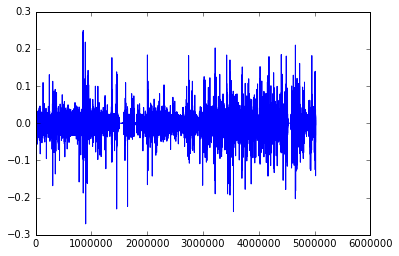

In [9]:
"Qerror Here running for all datasets"
np.random.seed(1)
sRerror=[0.01822398, 0.00189622,  0.00018295]
#sRerror=[1e-2,1e-3,0]
starteri=np.array([[4e-1,3e-1,1.5e-1],
                  [1e-1,1e-1,1e-1]])
starteri=np.vstack((starteri, np.random.rand(8,3)*2.8))
kolkuStarteri=len(starteri)
distances=np.zeros((3,0))

Qers=np.zeros((40,3))
QersDat={}
QersD=np.zeros((3,0))
for robotsII in range(40):
    robotsI,datas=(robotsII%5)+1,(robotsII//5)+1
    print('dataset , robot',datas,robotsI)
    odom,meas,groun,landDik=getAllMulti(datas,robotsI)
   
    if 'gOdomS' not in globals():
        gOdomS={}
    if robotsII not in gOdomS:
        gOdomS[robotsII]=getGrounForOdom(groun,odom)
    dist=calculateQerr(groun,odom,gOdomS[robotsII])
    disT=dist.T
    Qerror=np.cov(disT,ddof=0)
    
    Qers[robotsII]=Qerror.diagonal()
    
    if robotsI==1 and datas>1:
        print('all dataset size',QersD.shape)
        QersDat[datas-1]=np.cov(QersD,ddof=0).diagonal()
        QersD=np.zeros((3,0))
        
    print('\n\n Dobiena greska: ',Qerror.diagonal(),'\n\n',disT.shape,distances.shape)
    distances=np.hstack((distances,disT))
    QersD=np.hstack((QersD,disT))

print('all dataset size',QersD.shape)
QersDat[8]=np.cov(QersD,ddof=0).diagonal()

plt.plot(distances[2,:])

QersAll=np.cov(distances,ddof=0).diagonal()
print('all qers',QersAll)

if not os.path.isfile('QersN.all'):
    with open('QersN.all','wb') as f:
        pickle.dump((Qers,QersDat,QersAll),f)
else:
    with open('QersN.all','rb') as f:
        Qers,QersDat,QersAll=pickle.load(f)

In [8]:
with open('QersN.all','rb') as f:
    Qers,QersDat,QersAll=pickle.load(f)

In [26]:
allResesD={}
# with open('ResesD_new_complete.all','rb') as f:
#     allResesD=pickle.load(f)
Qers[38:],QersDat.keys()

(array([[  2.05609665e-07,   4.16019879e-07,   1.01873892e-05],
        [  1.68637875e-07,   2.18830542e-07,   1.17962986e-05]]),
 dict_keys([1, 2, 3, 4, 5, 6, 7, 8]))

In [27]:
from itertools import product
def print_sth(* sth,cond=False):
    if cond:
        for s in sth:
            print(s,flush=True)
def chooseQN(qNoise,datas,robotsII):        
    if qNoise=='neExperim':
        chooseQMat=QersDat[datas]
        retV=len(QersDat),datas
    elif qNoise=='neSingle':
        chooseQMat=Qers[robotsII]
        retV=len(Qers),robotsII
    elif qNoise=='neAll':
        chooseQMat=QersAll
        retV=len(QersAll),len(QersAll)
    else:
        sys.exit(-5)
    return chooseQMat,retV
def getChooseBin(whichBin):
    if whichBin=='parab':
        return 'parab'
    elif whichBin=='temp_parab':
        return 'parab'
    elif whichBin=='measDat':
        return '{0}datonev'
    elif whichBin=='measSingle':
        return '{1}rob'
    elif whichBin=='measAllWithEx':
        return 'all'
    elif whichBin=='measAllNoEx':
        return 'all_noEx'
    elif whichBin=='parab_noEx':
        return 'parab_noEx'
    sys.exit(-4)
def getChooseAvg(which):
    if which in ['parab','parab_noEx']:
        return 1
    elif which=='temp_parab':
        return -1
    else:
        return 0
listParam=[
    ['neAll'],#['neExperim','neSingle','neAll'],
    ['parab'],#['parab'],'measAllNoEx','measDat','measSingle'],
    ['withR'],
    ['multiL']
    #['singleL','multiL','doBestMultiL'],
    
]
allParam=product(*listParam)
for row in allParam:
    print(row)

('neAll', 'parab', 'withR', 'multiL')


In [28]:
"betws_less betws has with robots meas; betws no robots"



startingBetws='betws{}/data_{}_betw_{}.{}'
startingBins='bins/{}.bins_{}'
allParam=product(*listParam)

for rowI,rowP in enumerate(allParam):
    
    qNoise,whichBin,withR,singleL=rowP# neExperim...
    rowPrint=';'.join(rowP)
    
    allResesD[rowPrint]=[]
    
    chooseBin=getChooseBin(whichBin)
    chooseDoAverage=getChooseAvg(whichBin)
    isWithR='_simple'#BESTBESTBEST'_lessS' if withR=='withR' else '' 
    isSingleL=True if singleL=='singleL' else False
    shouldDoBest=True if 'doBest' in singleL else False

    for robotsII in range(40):
        # This is right
        if robotsII in [13,33,38,35,36]:
            continue
        # !!!!!!!!!!!!!!!
#     !!!!!!!!!!!!!!!!!!!!!
#         Only for BEST
#         if robotsII not in [16, 25, 15, 10, 11, 18]:
#             continue
        datas,robotsI=(robotsII//5)+1,(robotsII%5)+1
        
        odom,meas,groun,landDik=getAllMulti(datas,robotsI)
        measBetws=startingBetws.format(isWithR,datas,robotsI,'meas')
        grounBetws=startingBetws.format(isWithR,datas,robotsI,'groun')
        with open(measBetws,"rb") as f:
            bt_Ms,abt_Ms=pickle.load(f)
        with open(grounBetws,"rb") as f:
            bt_Gt=pickle.load(f)
        aBinName,dBinName=startingBins.format('angle',chooseBin.format(datas,robotsII)), \
        startingBins.format('distance',chooseBin.format(datas,robotsII))

        with open(aBinName,"rb") as f:
            aBin=pickle.load(f)

        with open(dBinName,"rb") as f:
            dBin=pickle.load(f)
        if 'gOdomS' not in globals():
            gOdomS={}
        if robotsII not in gOdomS:
            gOdomS[robotsII]=getGrounForOdom(groun,odom)

        chooseQMat,QName=chooseQN(qNoise,datas,robotsII)

        print_sth('\n\n======================\n\n'

                  +'{}\n\nLengthof Qer used/numInd:{}/{}; chooseDoAverage{}; isSingleL:{}' \
                  .format(rowPrint,QName[0],QName[1],chooseDoAverage,isSingleL)
                  ,'\nangleBinName:{}, distBinName:{}'.format(aBinName,dBinName),
                  '\nBetwsName:{} ; {}'.format(measBetws,grounBetws),
                  '\n datas {}; robotsI:{}; robotsII:{}'.format(datas,robotsI,robotsII),cond=(robotsI ==1))


        
        Qerror=np.eye(3)* chooseQMat
        
        postEd,xCalc,xTime,fInd,dist,kolkuNeP=process(groun,odom,meas,
                                        abt_Ms,landDik,gOdomS[robotsII],Qerror,
                                        dBin,aBin,isCorrect=True,doSingleLandmark=isSingleL,
                                        isAverageMin=chooseDoAverage,doBest=shouldDoBest) 
        disT=dist.T
        disT.shape
        Qerror=np.cov(disT,ddof=0)
        
        print_sth('\n===========================\nstarting value ',
                  cond=(rowI in [3,5]))
        print_sth('\r datset:{}/robotI:{}; Qerror: {}' \
              .format(datas,robotsI,
            Qerror.diagonal()) ,cond=(rowI in [3,5]))
               
            
            
        allResesD[rowPrint].append((Qerror,disT))

# winsound.Beep(2500,4000)

max_time = 4
f1 = 2000
f2 = 2200.0
rate = 4000.0
L = 3
times = np.linspace(0,L,rate*L)
signal = np.sin(2*np.pi*f1*times) + np.sin(2*np.pi*f2*times)
Audio(data=signal, rate=rate,autoplay=True)




neAll;parab;withR;multiL

Lengthof Qer used/numInd:3/3; chooseDoAverage1; isSingleL:False

angleBinName:bins/angle.bins_parab, distBinName:bins/distance.bins_parab

BetwsName:betws_simple/data_1_betw_1.meas ; betws_simple/data_1_betw_1.groun

 datas 1; robotsI:1; robotsII:0



neAll;parab;withR;multiL

Lengthof Qer used/numInd:3/3; chooseDoAverage1; isSingleL:False

angleBinName:bins/angle.bins_parab, distBinName:bins/distance.bins_parab

BetwsName:betws_simple/data_2_betw_1.meas ; betws_simple/data_2_betw_1.groun

 datas 2; robotsI:1; robotsII:5



neAll;parab;withR;multiL

Lengthof Qer used/numInd:3/3; chooseDoAverage1; isSingleL:False

angleBinName:bins/angle.bins_parab, distBinName:bins/distance.bins_parab

BetwsName:betws_simple/data_3_betw_1.meas ; betws_simple/data_3_betw_1.groun

 datas 3; robotsI:1; robotsII:10



neAll;parab;withR;multiL

Lengthof Qer used/numInd:3/3; chooseDoAverage1; isSingleL:False

angleBinName:bins/angle.bins_parab, distBinName:bins/distance.bins_para

NameError: name 'Audio' is not defined

In [29]:
print('len of reses',len(allResesD))
toSaveReses=True
if toSaveReses:
    with open('ResesD_new_simplified.all','wb') as f:
            pickle.dump(allResesD,f)

len of reses 1


In [61]:
Qers[13],QersDat[3]

(array([  2.97631358e-08,   3.88600691e-08,   3.76254396e-06]),
 array([  1.19669223e-07,   1.48512308e-07,   7.63300219e-06]))

In [62]:

startingBetws='betws{}/data_{}_betw_{}.{}'
startingBins='bins/{}.bins_{}'

qNoise,whichBin,withR,singleL='neAll;parab;withR;multiL'.split(';')
rowPrint=';'.join(rowP)


chooseBin=getChooseBin(whichBin)
chooseDoAverage=getChooseAvg(whichBin)
isWithR='_lessS' if withR=='withR' else '' 
isSingleL=True if singleL=='singleL' else False


for robotsII in range(5):
    if robotsII in [13,33,38,35,36]:
        continue

    datas,robotsI=(robotsII//5)+1,(robotsII%5)+1

    odom,meas,groun,landDik=getAllMulti(datas,robotsI)
    measBetws=startingBetws.format(isWithR,datas,robotsI,'meas')
    grounBetws=startingBetws.format(isWithR,datas,robotsI,'groun')
    with open(measBetws,"rb") as f:
        bt_Ms,abt_Ms=pickle.load(f)
    with open(grounBetws,"rb") as f:
        bt_Gt=pickle.load(f)
    aBinName,dBinName=startingBins.format('angle',chooseBin.format(datas,robotsII)), \
    startingBins.format('distance',chooseBin.format(datas,robotsII))

    with open(aBinName,"rb") as f:
        aBin=pickle.load(f)

    with open(dBinName,"rb") as f:
        dBin=pickle.load(f)
    if 'gOdomS' not in globals():
        gOdomS={}
    if robotsII not in gOdomS:
        gOdomS[robotsII]=getGrounForOdom(groun,odom)

    chooseQMat,QName=chooseQN(qNoise,datas,robotsII)

    print_sth('\n\n======================\n\n'

              +'{}\n\nLengthof Qer used/numInd:{}/{}; chooseDoAverage{}; isSingleL:{}' \
              .format(rowPrint,QName[0],QName[1],chooseDoAverage,isSingleL)
              ,'\nangleBinName:{}, distBinName:{}'.format(aBinName,dBinName),
              '\nBetwsName:{} ; {}'.format(measBetws,grounBetws),
              '\n datas {}; robotsI:{}; robotsII:{}'.format(datas,robotsI,robotsII),cond=(robotsI ==1))



    Qerror=np.eye(3)* chooseQMat

    postEd,xCalc,xTime,fInd,dist,kolkuNeP=process(groun,odom,meas,
                                    abt_Ms,landDik,gOdomS[robotsII],Qerror,
                                    dBin,aBin,isCorrect=True,doSingleLandmark=isSingleL,
                                    isAverageMin=chooseDoAverage)
    print('testing result', np.cov(dist.T,ddof=0).diagonal())




neAll;parab;withR;multiL

Lengthof Qer used/numInd:3/3; chooseDoAverage1; isSingleL:False

angleBinName:bins/angle.bins_parab, distBinName:bins/distance.bins_parab

BetwsName:betws_lessS/data_1_betw_1.meas ; betws_lessS/data_1_betw_1.groun

 datas 1; robotsI:1; robotsII:0
testing result [ 1.12857106  0.95761126  0.96363817]
testing result [ 0.90070068  0.67894554  0.58123873]
testing result [ 0.32357137  0.21421662  0.24609074]
testing result [ 2.97236826  2.41660571  1.49871006]
testing result [ 1.22432249  0.64641823  0.47897861]


In [9]:
listParam=[
    ['neAll'],
    ['parab'],
    ['withR'],
    ['multiL']
]
allParam=product(*listParam)
for row in allParam:
    print(row)

('neAll', 'parab', 'withR', 'multiL')


[65746 65747 65748 65745 65744 65749 65743 65750 65753 65751 65752 65742
 65736 65737 65735 65741 65738 65740 65739 65734]
[8406 8409 8407 8408 8410 8405 8404 8411 8412 8403 8402 8413 8320 8319 8318
 8414 8322 8323 8321 8401]


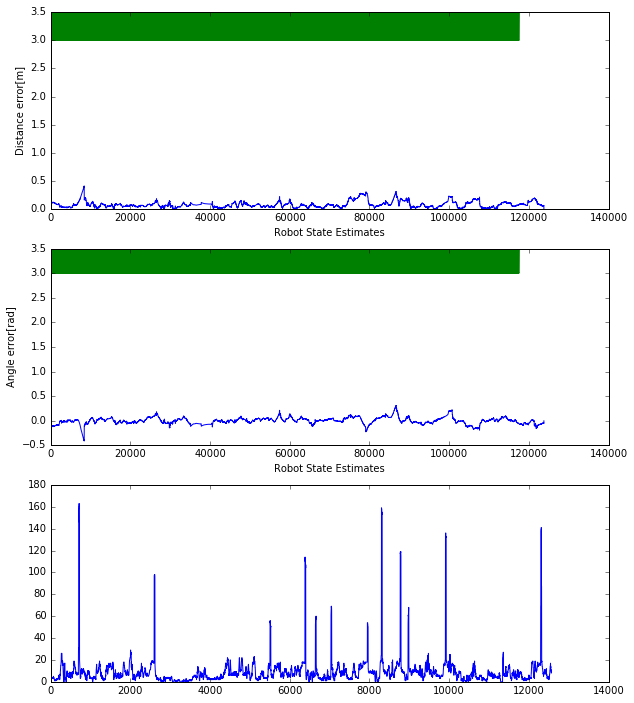

In [27]:
"Getting the separate dists"

allResesD={}

startingBetws='betws{}/data_{}_betw_{}.{}'
startingBins='bins/{}.bins_{}'
allParam=product(*listParam)

for rowI,rowP in enumerate(allParam):
    
    qNoise,whichBin,withR,singleL=rowP# neExperim...
    rowPrint=';'.join(rowP)
    
    allResesD[rowPrint]=[]
    
    chooseBin=getChooseBin(whichBin)
    chooseDoAverage=getChooseAvg(whichBin)
    isWithR='_lessS' if withR=='withR' else '' 
    isSingleL=True if singleL=='singleL' else False


    for robotsII in range(40):
        if robotsII not in [14, 4]:
            continue

        datas,robotsI=(robotsII//5)+1,(robotsII%5)+1
        
        odom,meas,groun,landDik=getAllMulti(datas,robotsI)
        measBetws=startingBetws.format(isWithR,datas,robotsI,'meas')
        grounBetws=startingBetws.format(isWithR,datas,robotsI,'groun')
        with open(measBetws,"rb") as f:
            bt_Ms,abt_Ms=pickle.load(f)
        with open(grounBetws,"rb") as f:
            bt_Gt=pickle.load(f)
        aBinName,dBinName=startingBins.format('angle',chooseBin.format(datas,robotsII)), \
        startingBins.format('distance',chooseBin.format(datas,robotsII))

        with open(aBinName,"rb") as f:
            aBin=pickle.load(f)

        with open(dBinName,"rb") as f:
            dBin=pickle.load(f)
        if 'gOdomS' not in globals():
            gOdomS={}
        if robotsII not in gOdomS:
            gOdomS[robotsII]=getGrounForOdom(groun,odom)

        chooseQMat,QName=chooseQN(qNoise,datas,robotsII)

        print_sth('\n\n======================\n\n'

                  +'{}\n\nLengthof Qer used/numInd:{}/{}; chooseDoAverage{}; isSingleL:{}' \
                  .format(rowPrint,QName[0],QName[1],chooseDoAverage,isSingleL)
                  ,'\nangleBinName:{}, distBinName:{}'.format(aBinName,dBinName),
                  '\nBetwsName:{} ; {}'.format(measBetws,grounBetws),
                  '\n datas {}; robotsI:{}; robotsII:{}'.format(datas,robotsI,robotsII),cond=(robotsI ==1))


        
        Qerror=np.eye(3)* chooseQMat
        
        postEd,xCalc,xTime,fInd,dist,kolkuNeP=process(groun,odom,meas,
                                        abt_Ms,landDik,gOdomS[robotsII],Qerror,
                                        dBin,aBin,isCorrect=True,doSingleLandmark=isSingleL,
                                        isAverageMin=chooseDoAverage) 
        disT=dist.T
        disT.shape
        Qerror=np.cov(disT,ddof=0)
        
        print_sth('\n===========================\nstarting value ',
                  cond=(rowI in [3,5]))
        print_sth('\r datset:{}/robotI:{}; Qerror: {}' \
              .format(datas,robotsI,
            Qerror.diagonal()) ,cond=(rowI in [3,5]))
               
            
            
        allResesD[rowPrint].append((dist,abt_Ms))
        
for i in range(2):
    aba=allResesD[rowPrint][i][1]
    abao=aba.copy()
    for ind,a in enumerate(aba):
        try:
            fro=ind-10 if ind-10>0 else 0
            aba[ind]=np.average(abao[fro:ind+10])
        except:
            print('ind ',ind-10,ind+10,abao[ind-10:ind+10],abao.shape)
    plotForDist(allResesD[rowPrint][i][0],False,aba)

In [37]:
import numpy as np



In [33]:
Audio(data=signal, rate=rate,autoplay=True)